In [24]:
%matplotlib inline
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import corner

from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective
from refnx.reflect import SLD, Slab, ReflectModel

In [25]:
# what is the refnx version
import refnx
print(refnx.version.version)

0.0.12.dev0+cd40977


In [26]:
DATASET_NAME = '/Users/andrew/progs/refnx/refnx/analysis/test/c_PLP0011859_q.txt'
USE_DIFFERENTIAL_EVOLUTION = True

# load the data
data = ReflectDataset(DATASET_NAME)

In [27]:
si = SLD(2.07, name='Si')
sio2 = SLD(3.47, name='SiO2')
film = SLD(2.0, name='film')
d2o = SLD(6.36, name='d2o')

sio2_layer = sio2(30, 3)
sio2_layer.thick.setp(bounds=(15, 50), vary=True)
sio2_layer.rough.setp(bounds=(1, 15), vary=True)

film_layer = film(250, 3)
film_layer.thick.setp(bounds=(200, 300), vary=True)
film_layer.sld.real.setp(bounds=(0.1, 3), vary=True)
film_layer.rough.setp(bounds=(1, 15), vary=True)

d2o_layer = d2o(0, 3)
d2o_layer.rough.setp(vary=True, bounds=(1, 15))

structure = si | sio2_layer | film_layer | d2o_layer

In [28]:
model = ReflectModel(structure, bkg=3e-6)
model.scale.setp(bounds=(0.6, 1.2), vary=True)
model.bkg.setp(bounds=(1e-9, 9e-6), vary=True)

In [29]:
objective = Objective(model, data, transform=Transform('logY'))

In [30]:
fitter = CurveFitter(objective, nwalkers=100)

# do the fit
%time res = fitter.fit('differential_evolution')

CPU times: user 17 s, sys: 877 ms, total: 17.9 s
Wall time: 9.51 s


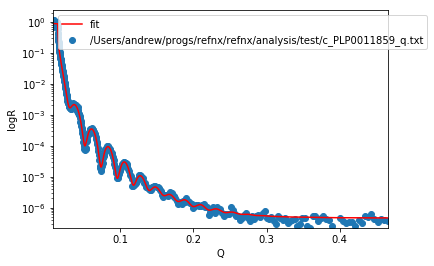

In [31]:
plt.scatter(data.x, data.y, label=DATASET_NAME)
plt.plot(data.x, model(data.x, x_err=data.x_err), color='r', label='fit')
plt.xlim(np.min(data.x), np.max(data.x))
plt.xlabel('Q')
plt.ylabel('logR')
plt.legend()
plt.yscale('log')

In [ ]:
plt.plot(*structure.sld_profile())

print(objective)

In [ ]:
fitter.sample(400)
fitter.sampler.reset()
%time res = fitter.sample(1000, nthin=10, pool=4)

/Users/andrew/anaconda3/lib/python3.6/site-packages/emcee-2.2.1-py3.6.egg/emcee/utils.py:43: RuntimeWarning: covariance is not positive-semidefinite.


Sampling progress: [###################################################] time remaining = 0 m:0 s
Sampling progress: [######################################            ] time remaining = 1 m:7 ss

This MCMC sampling gives a total of (1000 - 400) * 100 / 10 = 6000 samples.

In [ ]:
print(objective)

In [ ]:
a = corner.corner(fitter.sampler.flatchain)

In [ ]:
# plot a random selection of fits from a subset of the samples.

plt.scatter(data.x, data.y)

# the median fit
saved_params = np.array(objective.parameters)
plt.plot(data.x, model(data.x, x_err=data.x_err), color='r')

# Get 500 vectors, chosen randomly, set the objective, and plot the model.
for pvec in objective.pgen(ngen=500):
    objective.setp(pvec)
    plt.plot(data.x, model(data.x, x_err=data.x_err), color="k", alpha=0.01)
    
# put back saved_params
objective.setp(saved_params)

plt.ylim(np.min(data.y), np.max(data.y))
plt.xlim(np.min(data.x), np.max(data.x))
plt.yscale('log')

In [ ]:
saved_params = np.array(objective.parameters)

z, true_sld = structure.sld_profile()

for pvec in objective.pgen(ngen=500):
    objective.setp(pvec)
    zs, sld = structure.sld_profile()
    plt.plot(zs, sld, color='k', alpha=0.05)

# put back saved_params
objective.setp(saved_params)

plt.plot(z, true_sld, lw=1, color='r')
plt.ylim(2.2, 6)